In [3]:
from __future__  import print_function, division
import pylab as pl
import pandas as pd
import numpy as np
import os

%pylab inline

if os.getenv ('PUIDATA') is None:
    print ("Must set env variable PUIDATA")

import os
import json


Populating the interactive namespace from numpy and matplotlib


# IDEA:
## Older people are less likely than younger people to use bike during night time (21:00-5:00)

# NULL HYPOTHESIS:
## The ratio of older people (>=40) biking at night over all older people biking during a day is _the same_ or _higher_  than the ratio of younger people (< 40) biking at night to all the younger people biking during a day

## H0: $\frac{Y_{\mathrm{night}}}{Y_{\mathrm{24hour}}} <= \frac{O_{\mathrm{night}}}{O_{\mathrm{24hour}}}$
## H1: $\frac{Y_{\mathrm{night}}}{Y_{\mathrm{24hour}}} > \frac{O_{\mathrm{night}}}{O_{\mathrm{24hour}}}$

## I will use a significance level  $\alpha=0.05$

#### which means I want the probability of getting a result at least as significant as mine to be less then 5%

## I am starting with a single month of data:  reading data from citibike csv file from Jan 2015

what I want is the date and time of the beginning of each trip. pandas has an easy method to read csv files, and an easy method to convert strings to dates.

### download and move  data to PUIDATA
# NOTE: 
# 1. access to data from within the notebook _is required_
# 2. if data is downloaded it _must_ be stored in a directory pointed to by the environmental variable PUIDATA

In [4]:
### A function to download the data: simple bash commands can be run by preceding them with !
### but more complex command lines with variable arguments need to be build as strng and run with os.system
### this code cell does a lot of things: looks for existing files, download a file if none is there, unzips it, moves it.
### you do not have to have a code cell this complicated. 
### As long as 
### 1) your research is reproducible: we can access the same file as you without having to ask you for the file
### 2) and your data is stored in a directory pointed to by the env variable PUIDATA 
### you will be fine. We already explored how to download data in other notebooks!

def getCitiBikeCSV(datestring):
    print ("Downloading", datestring)
    ### First I will heck that it is not already there
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        if os.path.isfile(datestring + "-citibike-tripdata.csv"):
            # if in the current dir just move it
            if os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA")):
                print ("Error moving file!, Please check!")
        #otherwise start looking for the zip file
        else:
            if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip"):
                if not os.path.isfile(datestring + "-citibike-tripdata.zip"):
                    os.system("curl -O https://s3.amazonaws.com/tripdata/" + datestring + "-citibike-tripdata.zip")
                ###  To move it I use the os.system() functions to run bash commands with arguments
                os.system("mv " + datestring + "-citibike-tripdata.zip " + os.getenv("PUIDATA"))
            ### unzip the csv 
            os.system("unzip " + os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip")
            ## NOTE: old csv citibike data had a different name structure. 
            if '2014' in datestring:
                os.system("mv " + datestring[:4] + '-' +  datestring[4:] + 
                          "\ -\ Citi\ Bike\ trip\ data.csv " + datestring + "-citibike-tripdata.csv")
            os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA"))
    ### One final check:
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        print ("WARNING!!! something is wrong: the file is not there!")

    else:
        print ("file in place, you can continue")

In [5]:
datestring = '201501'
getCitiBikeCSV(datestring)

file in place, you can continue


In [6]:
df = pd.read_csv(os.getenv("PUIDATA") + "/" + datestring + '-citibike-tripdata.csv')
# df is the dataframe where the content of the csv file is stored
df['date'] = pd.to_datetime(df['starttime'])
# note that with dataframes I can refer to variables as dictionary keys, 
# i.e. df['starttime'] or as attributes: df.starttime. 
df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,date
0,1346,1/1/2015 0:01,1/1/2015 0:24,455,1 Ave & E 44 St,40.750020,-73.969053,265,Stanton St & Chrystie St,40.722293,-73.991475,18660,Subscriber,1960.0,2,2015-01-01 00:01:00
1,363,1/1/2015 0:02,1/1/2015 0:08,434,9 Ave & W 18 St,40.743174,-74.003664,482,W 15 St & 7 Ave,40.739355,-73.999318,16085,Subscriber,1963.0,1,2015-01-01 00:02:00
2,346,1/1/2015 0:04,1/1/2015 0:10,491,E 24 St & Park Ave S,40.740964,-73.986022,505,6 Ave & W 33 St,40.749013,-73.988484,20845,Subscriber,1974.0,1,2015-01-01 00:04:00
3,182,1/1/2015 0:04,1/1/2015 0:07,384,Fulton St & Waverly Ave,40.683178,-73.965964,399,Lafayette Ave & St James Pl,40.688515,-73.964763,19610,Subscriber,1969.0,1,2015-01-01 00:04:00
4,969,1/1/2015 0:05,1/1/2015 0:21,474,5 Ave & E 29 St,40.745168,-73.986831,432,E 7 St & Avenue A,40.726218,-73.983799,20197,Subscriber,1977.0,1,2015-01-01 00:05:00


In [7]:
df.columns

Index([u'tripduration', u'starttime', u'stoptime', u'start station id',
       u'start station name', u'start station latitude',
       u'start station longitude', u'end station id', u'end station name',
       u'end station latitude', u'end station longitude', u'bikeid',
       u'usertype', u'birth year', u'gender', u'date'],
      dtype='object')

In [8]:
df.drop(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'gender'], axis=1, inplace=True)

In [9]:
df.head()

,birth year,date
0,1960.0,2015-01-01 00:01:00
1,1963.0,2015-01-01 00:02:00
2,1974.0,2015-01-01 00:04:00
3,1969.0,2015-01-01 00:04:00
4,1977.0,2015-01-01 00:05:00


### Lets separate males (_m) from females (_w) to test the hypotheses.
### In this csv file gender == 1 is male, gender == 2 is female

### Lets plot the number of trips per week day

In [17]:
df['age']= 2017-df['birth year']

In [18]:
df.head()

,birth year,date,age
0,1960.0,2015-01-01 00:01:00,57.0
1,1963.0,2015-01-01 00:02:00,54.0
2,1974.0,2015-01-01 00:04:00,43.0
3,1969.0,2015-01-01 00:04:00,48.0
4,1977.0,2015-01-01 00:05:00,40.0


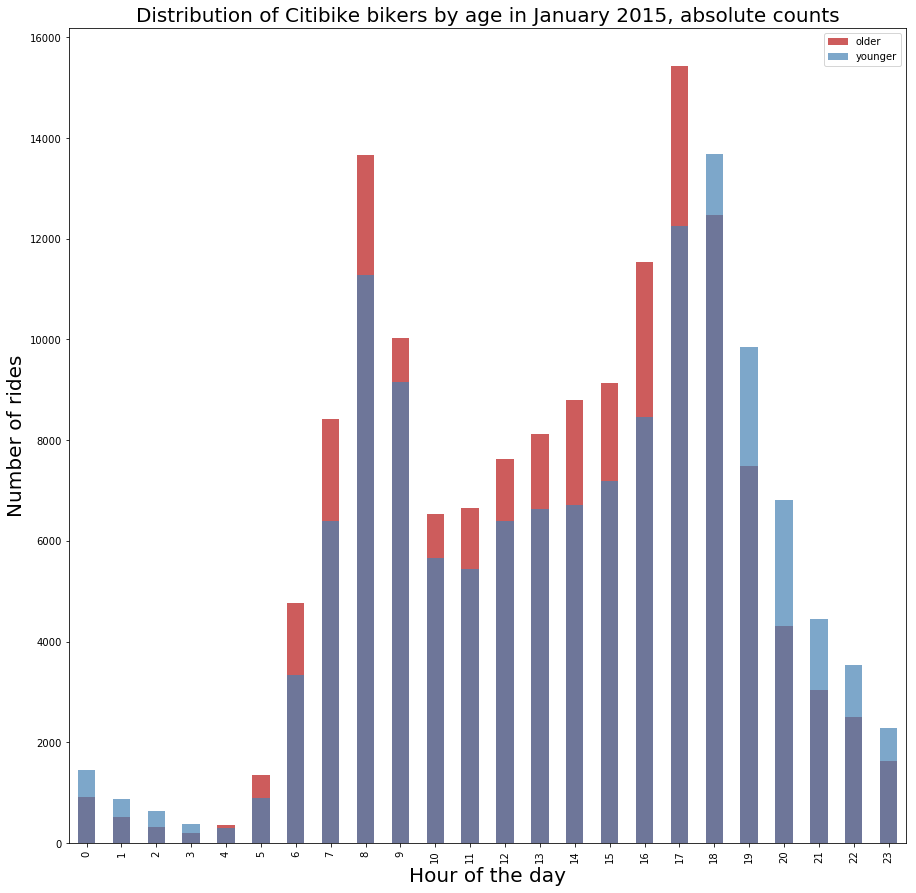

In [12]:
fig = pl.figure(figsize(15,15))
#instad of plotting with matplotlib i.e. plot() i use the plot method in pandas
norm_o = 1
((df['date'][df['age'] >= 40].groupby([df['date'].dt.hour]).count()) / norm_o).plot(kind="bar", 
                                                                                         color='IndianRed', 
                                                                                         label='older')

norm_y = 1
ax = ((df['date'][df['age'] < 40].groupby([df['date'].dt.hour]).count()) / norm_y).plot(kind="bar", 
                                                                                              color='SteelBlue', 
                                                                                              alpha=0.7,
                                                                                              label='younger')
pl.legend()
pl.title('Distribution of Citibike bikers by age in January 2015, absolute counts',fontsize=20)
pl.xlabel('Hour of the day',fontsize=20)
pl.ylabel('Number of rides',fontsize=20)

## Figure 1a: Distribution of Citibike bikers by age in January 2015, absolute counts

### Note: the counts have errors of course. what is the error on the count statistics? 
### for N counts the error is sqrt(N) - this is because counts follow a Poisson statistic

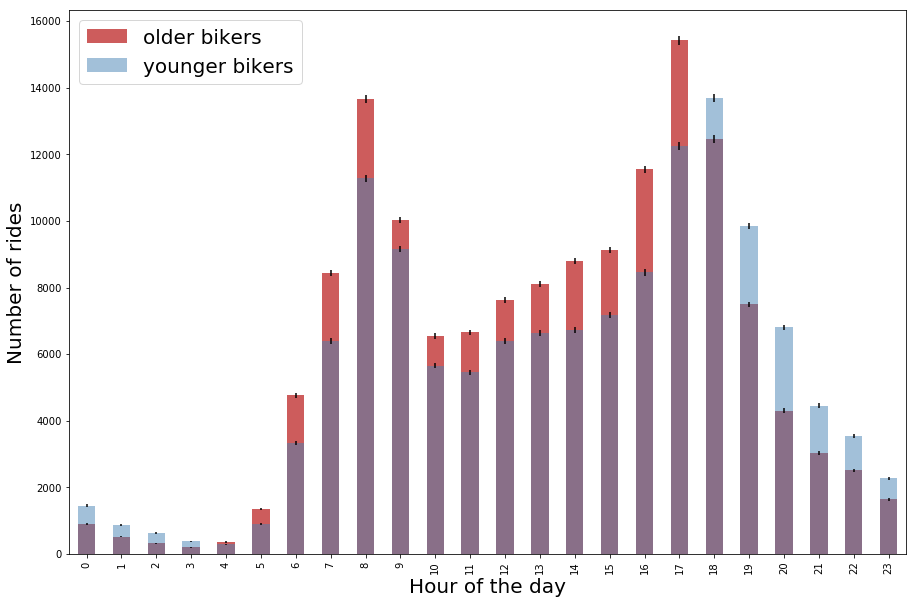

In [13]:
fig=pl.figure(figsize(15,10))

counts_o = df.date[df.age >= 40].groupby([df.date.dt.hour]).count()
norm_o = 1
error_o = np.sqrt(counts_o)
ax=((counts_o) / norm_o).plot(kind="bar",color='IndianRed',  yerr=[
            ((error_o) / norm_o, (error_o) / norm_o)], label='older bikers')


counts_y = df.date[df.age < 40].groupby([df.date.dt.hour]).count()
norm_y = 1
error_y=np.sqrt(counts_y)
((counts_y) / norm_y).plot(kind="bar", alpha=0.5, yerr=[((error_y) / norm_y, (error_y) / norm_y)], 
                           color='SteelBlue', label='younger bikers')
#ax.xaxis.set_ticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], fontsize=20)
ax.set_ylabel ("Number of rides",fontsize=20)
ax.set_xlabel ("Hour of the day",fontsize=20)
pl.legend(['older bikers','younger bikers'],fontsize=20)


## Figure 1b: Distribution of Citibike bikers by age in January 2015, absolute counts, with statistical errors

Note: These are absolute numbers. It is very hard to compare absolute numbers. Ratios (or proportions) are more ameable to comparison, so let's _normalize_ the distribution of man, and that of women, i.e. devide them by the total number of rides for that gender. 
(Notice that i have to normalize the errorbars too!)



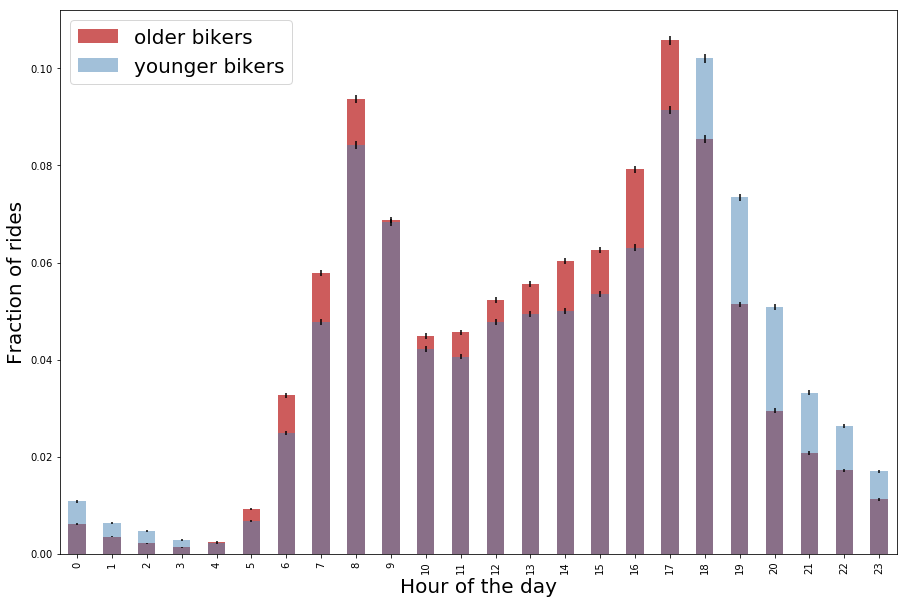

In [14]:
fig = pl.figure(figsize(15,10))

norm_o = counts_o.sum()
error_o = np.sqrt(counts_o)
((counts_o) / norm_o).plot(kind="bar", color='IndianRed',  
                           yerr=[((error_o) / norm_o, (error_o) / norm_o)], 
                           label='older bikers')

norm_y = counts_y.sum()
ax = ((counts_y) / norm_y).plot(kind="bar", alpha=0.5, 
                                yerr=[((error_y) / norm_y, (error_y) / norm_y)], 
                                color='SteelBlue', label='younger bikers')

ax.set_ylabel ("Fraction of rides",fontsize=20)
ax.set_xlabel ("Hour of the day",fontsize=20)

pl.legend(['older bikers','younger bikers'],fontsize=20)


## Figure 2: Distribution of Citibike bikers by age in January 2015, normalized